<a href="https://colab.research.google.com/github/tcheskko/TimeSeries_OceanAtmo/blob/main/OceanAtmoTimeSeries_XGBoost_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving OceanoAtmosferaDataSet.csv to OceanoAtmosferaDataSet.csv


#Ajustes no dataset 'OceanoAtmosferaDataSet'

In [71]:
dfOceanAtmo = pd.read_csv("OceanoAtmosferaDataSet.csv")
dfOceanAtmo.set_index('DATE', inplace=True)
dfOceanAtmo.head(10)

,PIR_SSS,PIR_DYN,PIR_PREC,PIR_SST,PIR_WSPD,PIR_WDIR,PIR_WDIRCR,INM_PREC_TOTAL,INM_TEMP_BSE,INM_UMID_AR,INM_VENT_DIR,INM_VENT_VEL,INM_VENT_DROS
DATE,,,,,,,,,,,,,
2018-01-01,37.21,98.63,0.00,26.61,3.40,199.10,WSW,0.00,25.70,73.00,359.00,2.70,SW
2018-01-02,37.22,99.70,0.00,26.65,3.40,190.20,S,0.00,26.70,73.00,354.00,1.40,ENE
2018-01-03,37.21,100.37,-0.04,26.61,4.20,206.20,WSW,0.00,24.90,66.00,126.00,2.00,ENE
2018-01-04,37.20,99.70,-0.02,26.68,3.70,196.20,WSW,0.00,26.80,54.00,294.00,1.70,SSW
2018-01-05,37.20,99.59,-0.02,26.74,3.60,229.30,W,0.00,26.60,63.00,337.00,2.90,SW
2018-01-06,37.20,99.57,-0.03,26.77,4.00,266.50,WNW,0.00,28.40,57.00,11.00,1.90,SW
2018-01-07,37.20,99.78,0.02,26.80,3.20,264.10,WNW,0.00,24.80,61.00,158.00,4.10,WSW
2018-01-08,37.20,99.87,0.00,26.80,4.00,276.60,WNW,0.00,23.00,71.00,162.00,1.80,S
2018-01-09,37.21,99.74,-0.02,26.83,4.90,295.30,NW,0.00,21.70,90.00,194.00,1.50,S


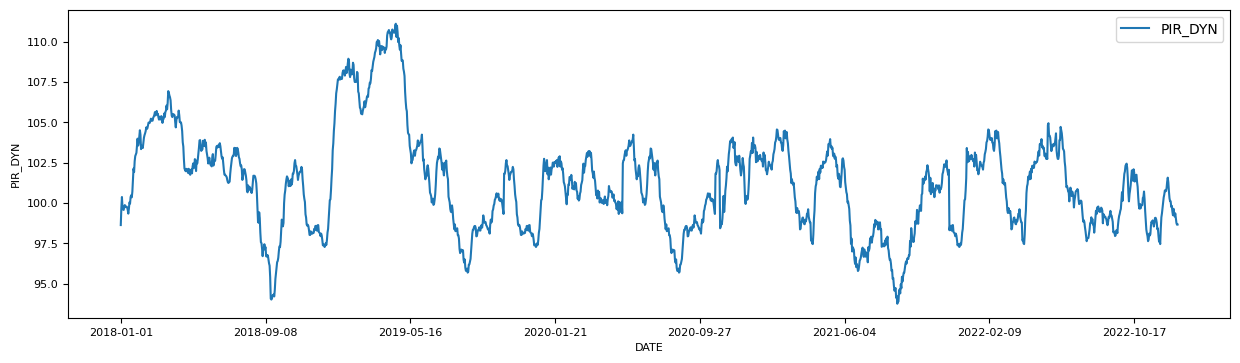

In [72]:
dfOceanAtmo.plot(y='PIR_DYN', subplots=True, figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('PIR_DYN', fontsize=8)
plt.show()

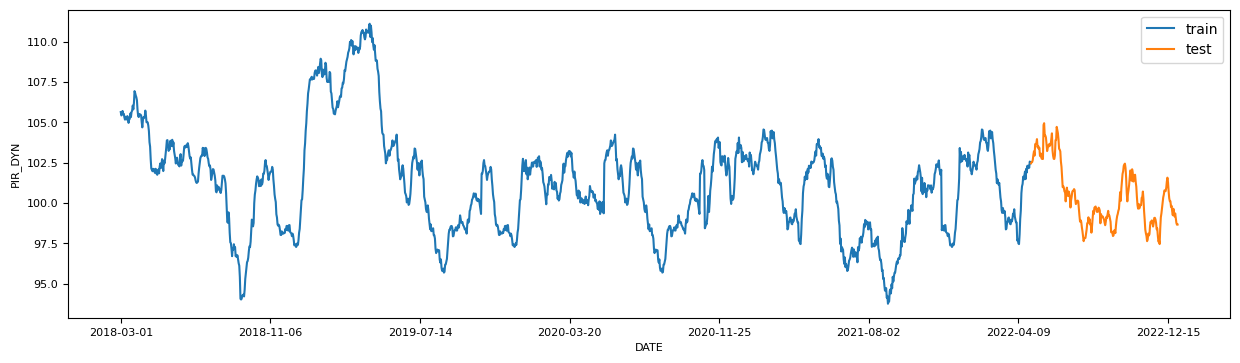

In [73]:
train_start_dt = '2018-03-01'
test_start_dt = '2022-04-30'

dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['PIR_DYN']].rename(columns={'PIR_DYN':'train'}) \
    .join(dfOceanAtmo[test_start_dt:][['PIR_DYN']].rename(columns={'PIR_DYN':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('PIR_DYN', fontsize=8)
plt.show()

In [74]:
timesteps=5

#[PIR_DYN] Dynamic Sea Surface

###Preparação dos dados para treinamento
* Filtragem e dimensionamento;


In [75]:
train_dyn = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['PIR_DYN']]
test_dyn = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['PIR_DYN']]

In [76]:
#Escalar dados
scaler = MinMaxScaler()
train_dyn['PIR_DYN'] = scaler.fit_transform(train_dyn)
test_dyn['PIR_DYN'] = scaler.transform(test_dyn)

In [77]:
# Converting to numpy arrays
train_data_dyn = train_dyn.values
test_data_dyn = test_dyn.values

In [78]:
train_data_timesteps_dyn = np.array([[j for j in train_data_dyn[i:i+timesteps]] for i in range(0,len(train_data_dyn)-timesteps+1)])[:,:,0]
test_data_timesteps_dyn = np.array([[j for j in test_data_dyn[i:i+timesteps]] for i in range(0,len(test_data_dyn)-timesteps+1)])[:,:,0]

print(test_data_timesteps_dyn.shape)
print(train_data_timesteps_dyn.shape)

(242, 5)
(1517, 5)


In [79]:
#train
x_train_dyn, y_train_dyn = train_data_timesteps_dyn[:,:timesteps-1],train_data_timesteps_dyn[:,[timesteps-1]]

#test
x_test_dyn, y_test_dyn = test_data_timesteps_dyn[:,:timesteps-1],test_data_timesteps_dyn[:,[timesteps-1]]

In [80]:
# XGBoost
cv_split_dyn = TimeSeriesSplit(n_splits=2, test_size=timesteps)
model_dyn = XGBRegressor()

parameters_dyn = {  "max_depth": [3, 4, 6, 5],
                    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
                    "n_estimators": [100, 300, 500, 700, 900, 1000],
                    "colsample_bytree": [0.3, 0.5, 0.7]  }


grid_search_dyn = GridSearchCV(estimator=model_dyn, cv=cv_split_dyn, param_grid=parameters_dyn)
grid_search_dyn.fit(x_train_dyn, y_train_dyn)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=5),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, import...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [81]:
#LGBM
#cv_split = TimeSeriesSplit(n_splits=2, test_size=timesteps)
#model_dyn = lgb.LGBMRegressor()
#parameters = {
    #"max_depth": [3, 4, 6],
    #"num_leaves": [10, 20, 30],
    #"learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    #"n_estimators": [50, 100, 300],
    #"colsample_bytree": [0.3, 0.5, 0.7],
    #"force_col_wise": ["true"]
#}


#grid_search_dyn = GridSearchCV(estimator=model_dyn, cv=cv_split, param_grid=parameters)
#grid_search_dyn.fit(x_train_dyn, y_train_dyn)

In [82]:
#predictions

y_train_pred_dyn = grid_search_dyn.predict(x_train_dyn).reshape(-1,1)
y_test_pred_dyn = grid_search_dyn.predict(x_test_dyn).reshape(-1,1)

In [83]:
#ReScaling orginial and predicted

y_train_dyn = scaler.inverse_transform(y_train_dyn)
y_test_dyn = scaler.inverse_transform(y_test_dyn)

y_train_pred_dyn = scaler.inverse_transform(y_train_pred_dyn)
y_test_pred_dyn = scaler.inverse_transform(y_test_pred_dyn)

In [84]:
train_timestamps_dyn = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)].index[timesteps-1:]
test_timestamps_dyn = dfOceanAtmo[test_start_dt:].index[timesteps-1:]

In [183]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [144]:
print('MAPE for test data: ', mape(pd.DataFrame(y_test_pred_dyn),pd.DataFrame(y_test_dyn))*100, '%')

MAPE for training data:  0   0.36
dtype: float64 %


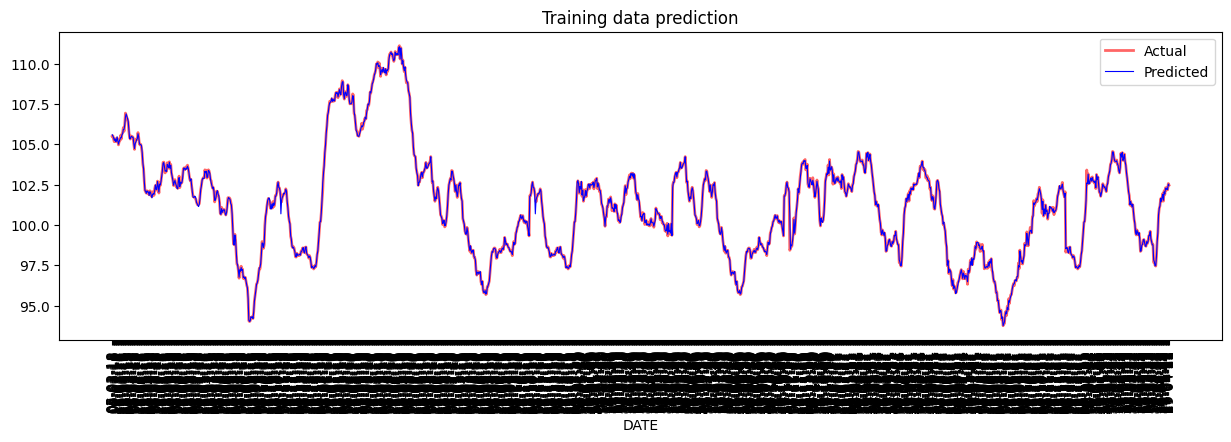

In [85]:
plt.figure(figsize=(15,4))
plt.plot(train_timestamps_dyn, y_train_dyn, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps_dyn, y_train_pred_dyn, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(train_timestamps_dyn, pd.to_datetime(train_timestamps_dyn).strftime('%d-%m-%y'), rotation=90)
plt.title("Training data prediction")
plt.show()

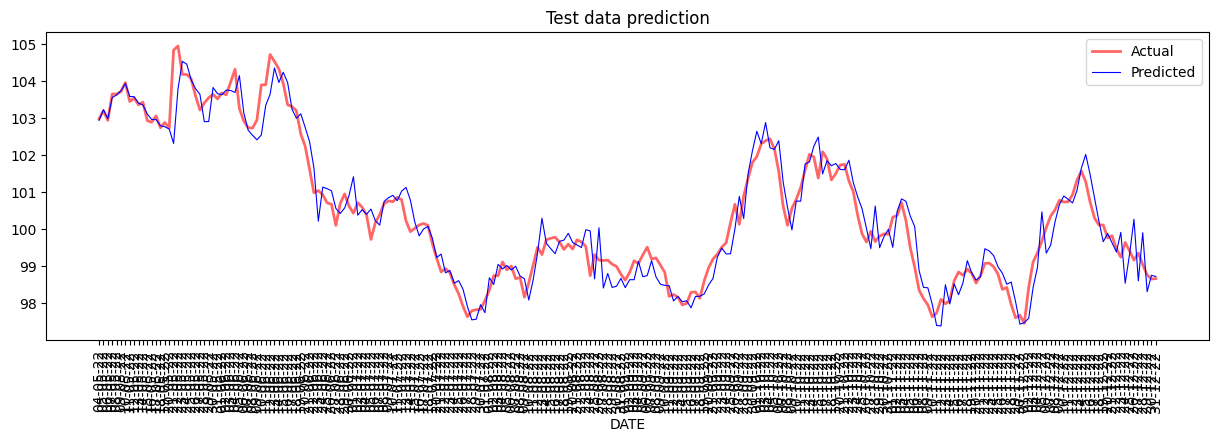

In [86]:
plt.figure(figsize=(15,4))
plt.plot(test_timestamps_dyn, y_test_dyn, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps_dyn, y_test_pred_dyn, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(test_timestamps_dyn, pd.to_datetime(test_timestamps_dyn).strftime('%d-%m-%y'), rotation=90)
plt.title("Test data prediction")
plt.show()

<Axes: xlabel='DATE'>

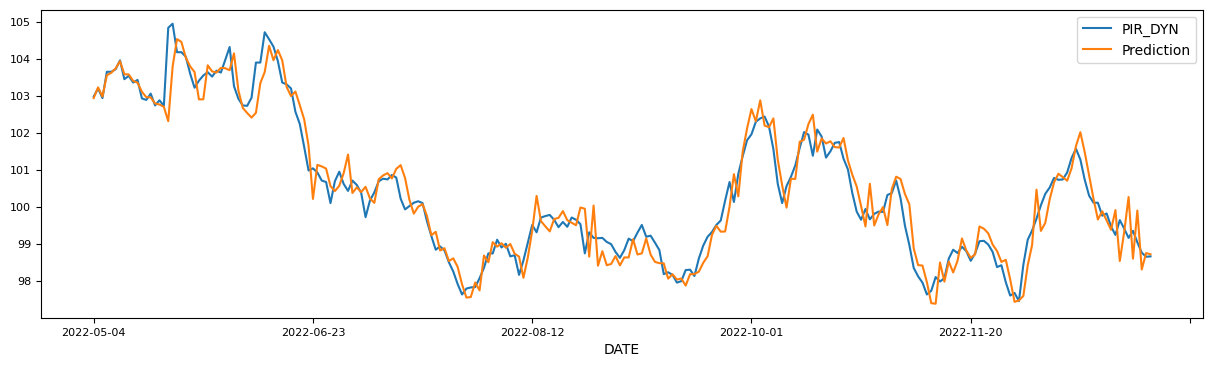

In [141]:
listY_dyn = pd.DataFrame(y_test_dyn.tolist(), columns=['PIR_DYN'])
listY_pred_dyn = pd.DataFrame(y_test_pred_dyn.tolist(), columns=['Prediction'])
listX_idx_dyn = pd.DataFrame(test_timestamps_dyn.tolist(), columns=['DATE'])


dfFull_dyn = pd.concat([listX_idx_dyn, listY_dyn, listY_pred_dyn], axis=1);
dfFull_dyn.set_index('DATE', inplace=True)

dfFull_dyn.plot(figsize=(15, 4), fontsize=8)

###Full dataset prediction

In [87]:
full_dyn_indexes = dfOceanAtmo.index.values
full_dyn_indexes_X = np.array([[j for j in full_dyn_indexes[i:i+timesteps]] for i in range(0,len(full_dyn_indexes)-timesteps+1)])[:,0]

full_dyn = dfOceanAtmo[['PIR_DYN']].values
full_dyn = scaler.fit_transform(full_dyn)

# Transforming to 2D tensor as per model input requirement
data_timesteps_dyn = np.array([[j for j in full_dyn[i:i+timesteps]] for i in range(0,len(full_dyn)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps_dyn.shape)

# Selecting inputs and outputs from data
X_full_dyn, Y_full_dyn = data_timesteps_dyn[:,:timesteps-1],data_timesteps_dyn[:,[timesteps-1]]

print("X shape: ", X_full_dyn.shape,"\nY shape: ", Y_full_dyn.shape)
print("X index: ", full_dyn_indexes_X.shape)

Tensor shape:  (1822, 5)
X shape:  (1822, 4) 
Y shape:  (1822, 1)
X index:  (1822,)


In [88]:
# Make model predictions
Y_full_pred_dyn = grid_search_dyn.predict(X_full_dyn).reshape(-1,1)

# Inverse scale and reshape
Y_full_pred_dyn = scaler.inverse_transform(Y_full_pred_dyn)
Y_full_dyn = scaler.inverse_transform(Y_full_dyn)

<Axes: xlabel='DATE'>

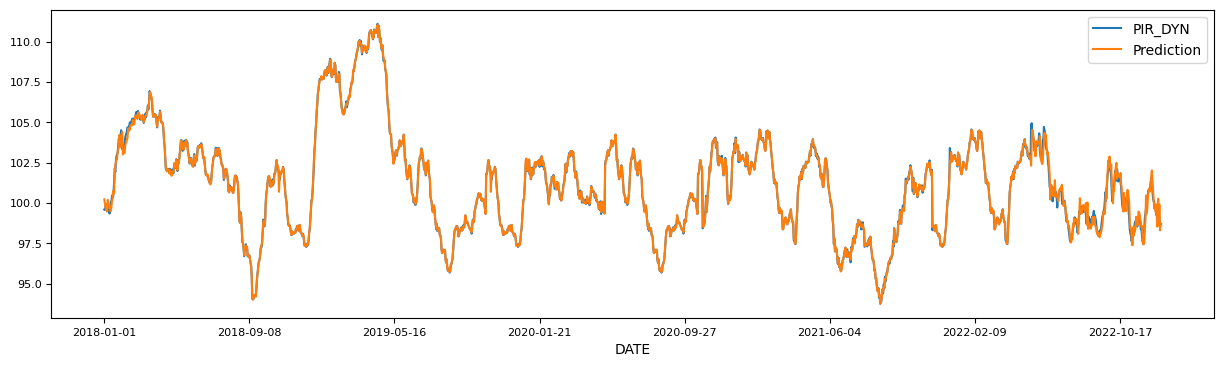

In [89]:
listY_dyn = pd.DataFrame(Y_full_dyn.tolist(), columns=['PIR_DYN'])
listY_pred_dyn = pd.DataFrame(Y_full_pred_dyn.tolist(), columns=['Prediction'])
listX_idx_dyn = pd.DataFrame(full_dyn_indexes_X.tolist(), columns=['DATE'])


dfFull = pd.concat([listX_idx_dyn, listY_dyn, listY_pred_dyn], axis=1);
dfFull.set_index('DATE', inplace=True)

dfFull.plot(figsize=(15, 4), fontsize=8)

<Axes: xlabel='DATE'>

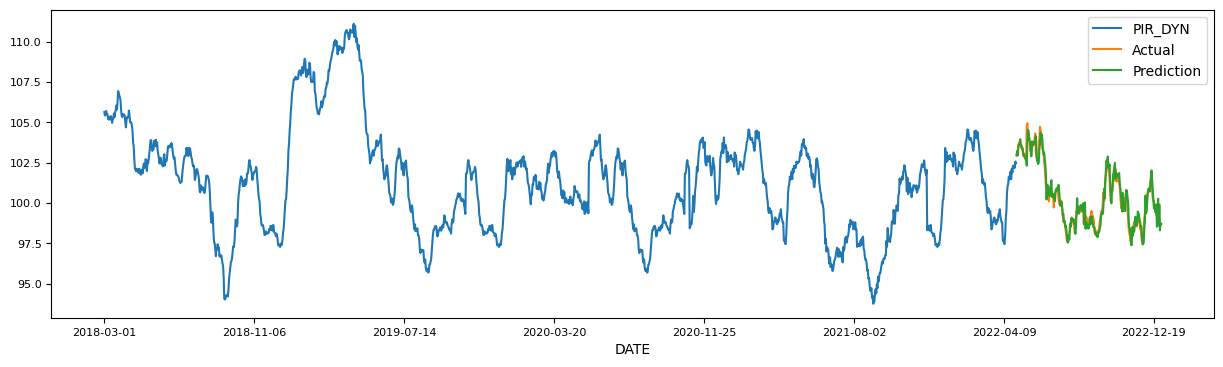

In [90]:
train_c_dyn = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['PIR_DYN']].rename(columns={'PIR_DYN':'PIR_DYN'})

df_pred_dyn = pd.DataFrame(y_test_pred_dyn.tolist(), columns=['Prediction'])
df_actual_dyn = pd.DataFrame(y_test_dyn.tolist(), columns=['Actual'])
df_dates = pd.DataFrame(test_timestamps_dyn.tolist(), columns=['DATE'])

df_conc = pd.concat([df_dates,df_actual_dyn,df_pred_dyn],axis=1)
df_conc.set_index('DATE', inplace=True)


pd.concat([train_c_dyn,df_conc],axis=1).plot(figsize=(15, 4), fontsize=8)

#[PIR_SST] Sea Surface Temperature


###Preparação dos dados para treinamento
* Filtragem e dimensionamento;


In [91]:
train_sst = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['PIR_SST']]
test_sst = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['PIR_SST']]

In [92]:
#Escalar dados
train_sst['PIR_SST'] = scaler.fit_transform(train_sst)
test_sst['PIR_SST'] = scaler.transform(test_sst)

In [93]:
# Converting to numpy arrays
train_data_sst = train_sst.values
test_data_sst = test_sst.values

In [94]:
train_data_timesteps_sst = np.array([[j for j in train_data_sst[i:i+timesteps]] for i in range(0,len(train_data_sst)-timesteps+1)])[:,:,0]
test_data_timesteps_sst = np.array([[j for j in test_data_sst[i:i+timesteps]] for i in range(0,len(test_data_sst)-timesteps+1)])[:,:,0]

print(test_data_timesteps_sst.shape)
print(train_data_timesteps_sst.shape)

(242, 5)
(1517, 5)


In [95]:
#train
x_train_sst, y_train_sst = train_data_timesteps_sst[:,:timesteps-1],train_data_timesteps_sst[:,[timesteps-1]]

#test
x_test_sst, y_test_sst = test_data_timesteps_sst[:,:timesteps-1],test_data_timesteps_sst[:,[timesteps-1]]

In [96]:
# XGBoost
cv_split_sst = TimeSeriesSplit(n_splits=2, test_size=timesteps)
model_sst = XGBRegressor()

parameters_sst = {  "max_depth": [3, 4, 6, 5],
                    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
                    "n_estimators": [100, 300, 500, 700, 900, 1000],
                    "colsample_bytree": [0.3, 0.5, 0.7]  }


grid_search_sst = GridSearchCV(estimator=model_sst, cv=cv_split_sst, param_grid=parameters_sst)
grid_search_sst.fit(x_train_sst, y_train_sst)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=5),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, import...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [97]:
# LGBM
#cv_split_sst = TimeSeriesSplit(n_splits=2, test_size=timesteps)
#model_sst = lgb.LGBMRegressor()
#parameters_sst = {
    #"max_depth": [3, 4, 6],
    #"num_leaves": [10, 20, 30],
    #"learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    #"n_estimators": [50, 100, 300],
    #"colsample_bytree": [0.3, 0.5, 0.7],
    #"force_col_wise": ["true"]
#}


#grid_search_sst = GridSearchCV(estimator=model_sst, cv=cv_split_sst, param_grid=parameters_sst)
#grid_search_sst.fit(x_train_sst, y_train_sst)

In [98]:
#predictions

y_train_pred_sst = grid_search_sst.predict(x_train_sst).reshape(-1,1)
y_test_pred_sst = grid_search_sst.predict(x_test_sst).reshape(-1,1)

In [99]:
#ReScaling orginial and predicted

y_train_sst = scaler.inverse_transform(y_train_sst)
y_test_sst = scaler.inverse_transform(y_test_sst)

y_train_pred_sst = scaler.inverse_transform(y_train_pred_sst)
y_test_pred_sst = scaler.inverse_transform(y_test_pred_sst)

In [100]:
train_timestamps_sst = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)].index[timesteps-1:]
test_timestamps_sst = dfOceanAtmo[test_start_dt:].index[timesteps-1:]

In [143]:
print('MAPE for test data: ', mape(pd.DataFrame(y_test_pred_sst),pd.DataFrame(y_test_sst))*100, '%')

MAPE for training data:  0   0.42
dtype: float64 %


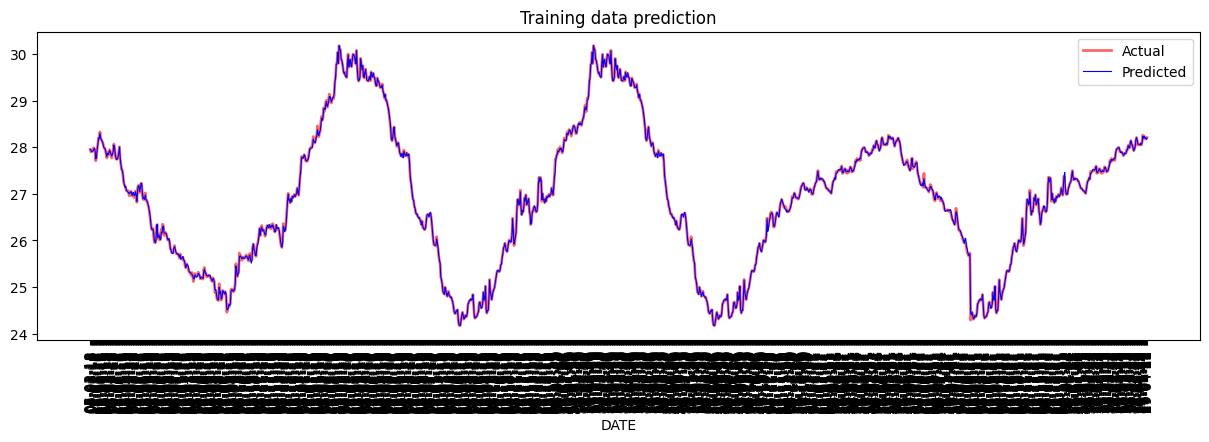

In [101]:
plt.figure(figsize=(15,4))
plt.plot(train_timestamps_sst, y_train_sst, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps_sst, y_train_pred_sst, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(train_timestamps_sst, pd.to_datetime(train_timestamps_sst).strftime('%d-%m-%y'), rotation=90)
plt.title("Training data prediction")
plt.show()

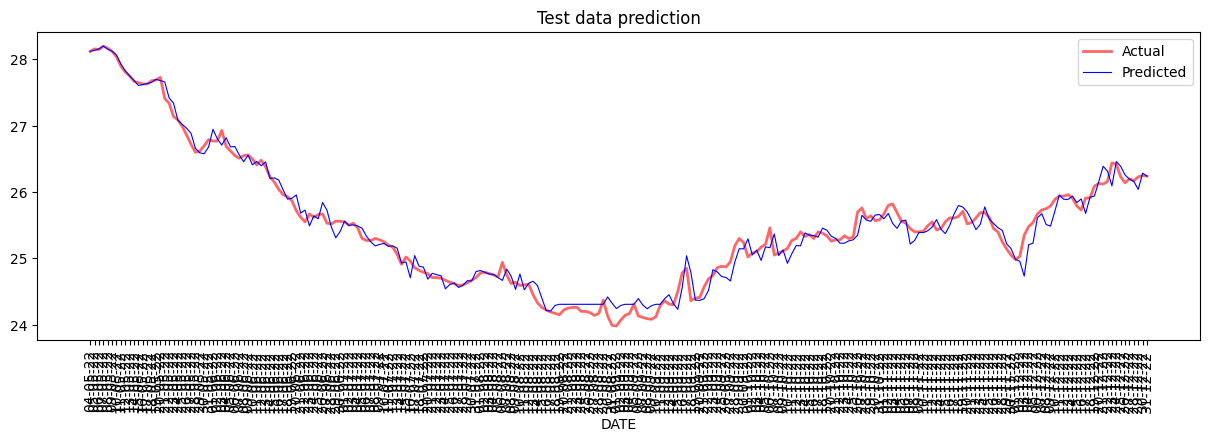

In [102]:
plt.figure(figsize=(15,4))
plt.plot(test_timestamps_sst, y_test_sst, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps_sst, y_test_pred_sst, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(test_timestamps_sst, pd.to_datetime(test_timestamps_sst).strftime('%d-%m-%y'), rotation=90)
plt.title("Test data prediction")
plt.show()

<Axes: xlabel='DATE'>

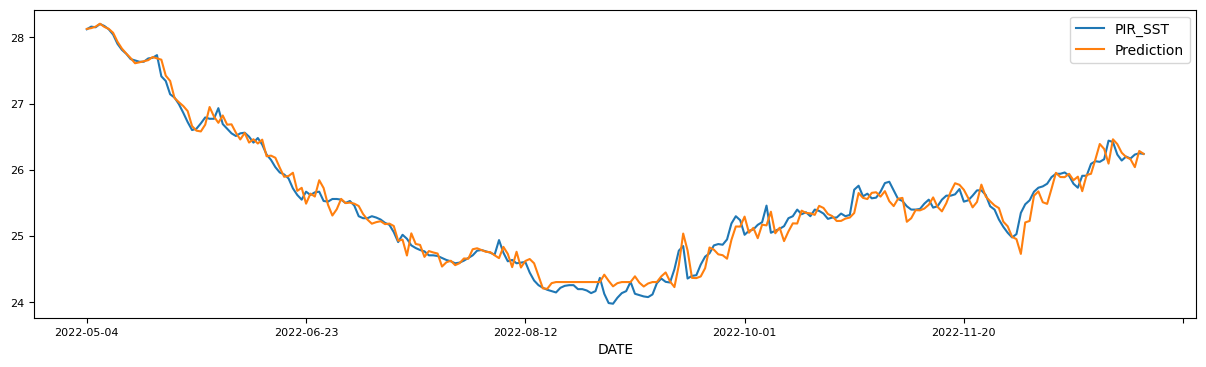

In [145]:
listY_sst = pd.DataFrame(y_test_sst.tolist(), columns=['PIR_SST'])
listY_pred_sst = pd.DataFrame(y_test_pred_sst.tolist(), columns=['Prediction'])
listX_idx_sst = pd.DataFrame(test_timestamps_sst.tolist(), columns=['DATE'])


dfTrain_sst = pd.concat([listX_idx_sst, listY_sst, listY_pred_sst], axis=1);
dfTrain_sst.set_index('DATE', inplace=True)

dfTrain_sst.plot(figsize=(15, 4), fontsize=8)

###Full dataset prediction

In [103]:
full_sst_indexes = dfOceanAtmo.index.values
full_sst_indexes_X = np.array([[j for j in full_sst_indexes[i:i+timesteps]] for i in range(0,len(full_sst_indexes)-timesteps+1)])[:,0]

full_sst = dfOceanAtmo[['PIR_SST']].values
full_sst = scaler.fit_transform(full_sst)

# Transforming to 2D tensor as per model input requirement
data_timesteps_sst = np.array([[j for j in full_sst[i:i+timesteps]] for i in range(0,len(full_sst)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps_sst.shape)

# Selecting inputs and outputs from data
X_full_sst, Y_full_sst = data_timesteps_sst[:,:timesteps-1],data_timesteps_sst[:,[timesteps-1]]

print("X shape: ", X_full_sst.shape,"\nY shape: ", Y_full_sst.shape)
print("X index: ", full_sst_indexes_X.shape)

Tensor shape:  (1822, 5)
X shape:  (1822, 4) 
Y shape:  (1822, 1)
X index:  (1822,)


In [104]:
# Make model predictions
Y_full_pred_sst = grid_search_sst.predict(X_full_sst).reshape(-1,1)

# Inverse scale and reshape
Y_full_pred_sst = scaler.inverse_transform(Y_full_pred_sst)
Y_full_sst = scaler.inverse_transform(Y_full_sst)

<Axes: xlabel='DATE'>

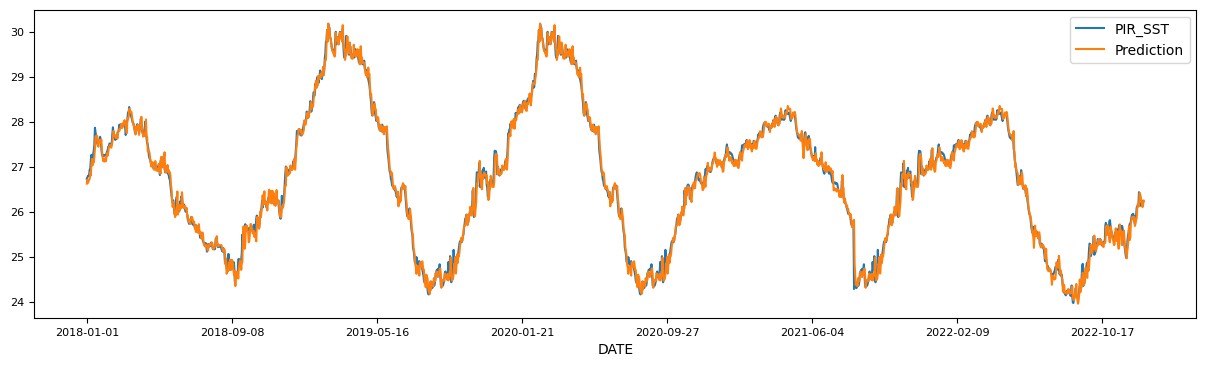

In [105]:
listY_sst = pd.DataFrame(Y_full_sst.tolist(), columns=['PIR_SST'])
listY_pred_sst = pd.DataFrame(Y_full_pred_sst.tolist(), columns=['Prediction'])
listX_idx_sst = pd.DataFrame(full_sst_indexes_X.tolist(), columns=['DATE'])


dfFull = pd.concat([listX_idx_sst, listY_sst, listY_pred_sst], axis=1);
dfFull.set_index('DATE', inplace=True)

dfFull.plot(figsize=(15, 4), fontsize=8)

<Axes: xlabel='DATE'>

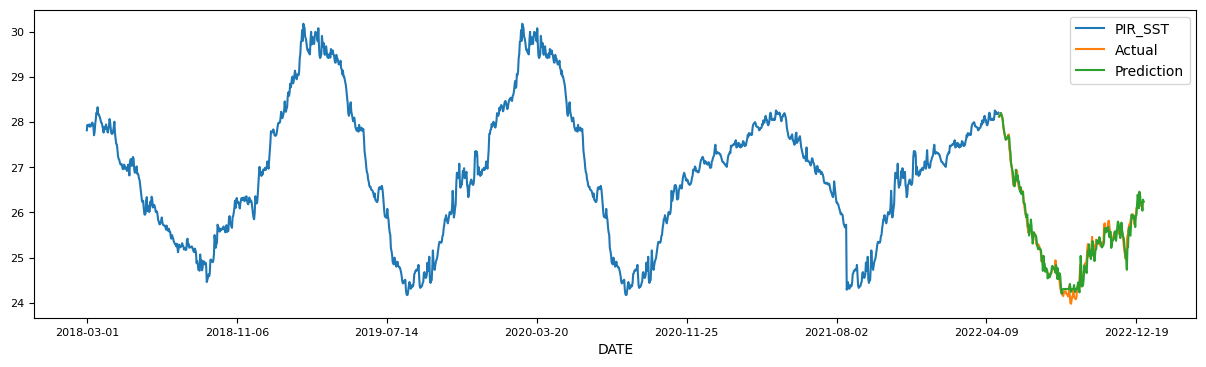

In [106]:
train_c_sst = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['PIR_SST']].rename(columns={'PIR_SST':'PIR_SST'})

df_pred_sst = pd.DataFrame(y_test_pred_sst.tolist(), columns=['Prediction'])
df_actual_sst = pd.DataFrame(y_test_sst.tolist(), columns=['Actual'])
df_dates_sst = pd.DataFrame(test_timestamps_sst.tolist(), columns=['DATE'])

df_conc_sst = pd.concat([df_dates_sst,df_actual_sst,df_pred_sst],axis=1)
df_conc_sst.set_index('DATE', inplace=True)


pd.concat([train_c_sst,df_conc_sst],axis=1).plot(figsize=(15, 4), fontsize=8)

#[INM_PREC_TOTAL] Precipitação total

###Preparação dos dados para treinamento
* Filtragem e dimensionamento;


In [186]:
train_prt = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['INM_PREC_TOTAL']]
test_prt = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['INM_PREC_TOTAL']]

In [187]:
#Escalar dados
#train_prt['INM_PREC_TOTAL'] = scaler.fit_transform(train_prt)
#test_prt['INM_PREC_TOTAL'] = scaler.transform(test_prt)

In [188]:
# Converting to numpy arrays
train_data_prt = train_prt.values
test_data_prt = test_prt.values

In [189]:
train_data_timesteps_prt = np.array([[j for j in train_data_prt[i:i+timesteps]] for i in range(0,len(train_data_prt)-timesteps+1)])[:,:,0]
test_data_timesteps_prt = np.array([[j for j in test_data_prt[i:i+timesteps]] for i in range(0,len(test_data_prt)-timesteps+1)])[:,:,0]

print(test_data_timesteps_prt.shape)
print(train_data_timesteps_prt.shape)

(242, 5)
(1517, 5)


In [190]:
#train
x_train_prt, y_train_prt = train_data_timesteps_prt[:,:timesteps-1],train_data_timesteps_prt[:,[timesteps-1]]

#test
x_test_prt, y_test_prt = test_data_timesteps_prt[:,:timesteps-1],test_data_timesteps_prt[:,[timesteps-1]]

In [191]:
# XGBoost
cv_split_prt = TimeSeriesSplit(n_splits=2, test_size=timesteps)
model_prt = XGBRegressor()

parameters_prt = {  "max_depth": [3, 4, 6, 5],
                    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
                    "n_estimators": [100, 300, 500, 700, 900, 1000],
                    "colsample_bytree": [0.3, 0.5, 0.7]  }


grid_search_prt = GridSearchCV(estimator=model_prt, cv=cv_split_prt, param_grid=parameters_prt)
grid_search_prt.fit(x_train_prt, y_train_prt)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=5),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, import...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [192]:
# LGBM
#cv_split_prt = TimeSeriesSplit(n_splits=2, test_size=timesteps)
#model_prt = lgb.LGBMRegressor()
#parameters_prt = {
    #"max_depth": [3, 4, 6],
    #"num_leaves": [10, 20, 30],
    #"learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    #"n_estimators": [50, 100, 300],
    #"colsample_bytree": [0.3, 0.5, 0.7],
    #"force_col_wise": ["true"]
#}


#grid_search_prt = GridSearchCV(estimator=model_prt, cv=cv_split_prt, param_grid=parameters_prt)
#grid_search_prt.fit(x_train_prt, y_train_prt)

In [193]:
#predictions

y_train_pred_prt = grid_search_prt.predict(x_train_prt).reshape(-1,1)
y_test_pred_prt = grid_search_prt.predict(x_test_prt).reshape(-1,1)

In [194]:
#ReScaling orginial and predicted

y_train_prt = scaler.inverse_transform(y_train_prt)
y_test_prt = scaler.inverse_transform(y_test_prt)

y_train_pred_prt = scaler.inverse_transform(y_train_pred_prt)
y_test_pred_prt = scaler.inverse_transform(y_test_pred_prt)

In [195]:
train_timestamps_prt = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)].index[timesteps-1:]
test_timestamps_prt = dfOceanAtmo[test_start_dt:].index[timesteps-1:]

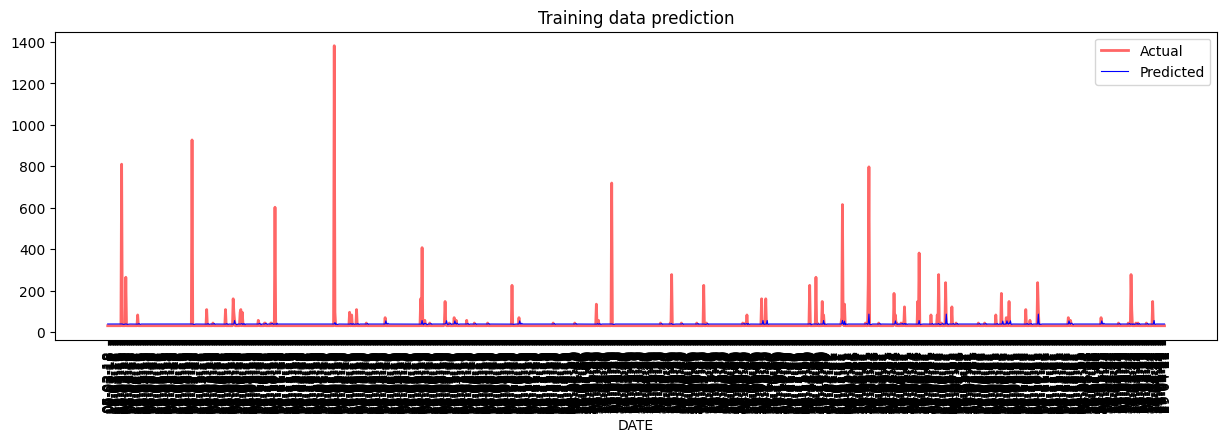

In [196]:
plt.figure(figsize=(15,4))
plt.plot(train_timestamps_prt, y_train_prt, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps_prt, y_train_pred_prt, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(train_timestamps_prt, pd.to_datetime(train_timestamps_prt).strftime('%d-%m-%y'), rotation=90)
plt.title("Training data prediction")
plt.show()

In [197]:
print('MAPE for training data: ', mape(pd.DataFrame(y_test_pred_prt), pd.DataFrame(y_test_prt))*100, '%')

MAPE for training data:  0   30.45
dtype: float64 %


In [198]:
#https://stephenallwright.com/calculate-mape-with-0-values/
def smape(actuals, predictions):
    return 1/len(actuals) * np.sum(2 * np.abs(predictions - actuals) / (np.abs(actuals) + np.abs(predictions)))

print('One step forecast SMAPE: ', (smape(pd.DataFrame(y_test_prt), pd.DataFrame(y_test_pred_prt))), '%')

One step forecast SMAPE:  0   0.30
dtype: float64 %


In [ ]:
pd.DataFrame(y_test_pred_prt).head(10)

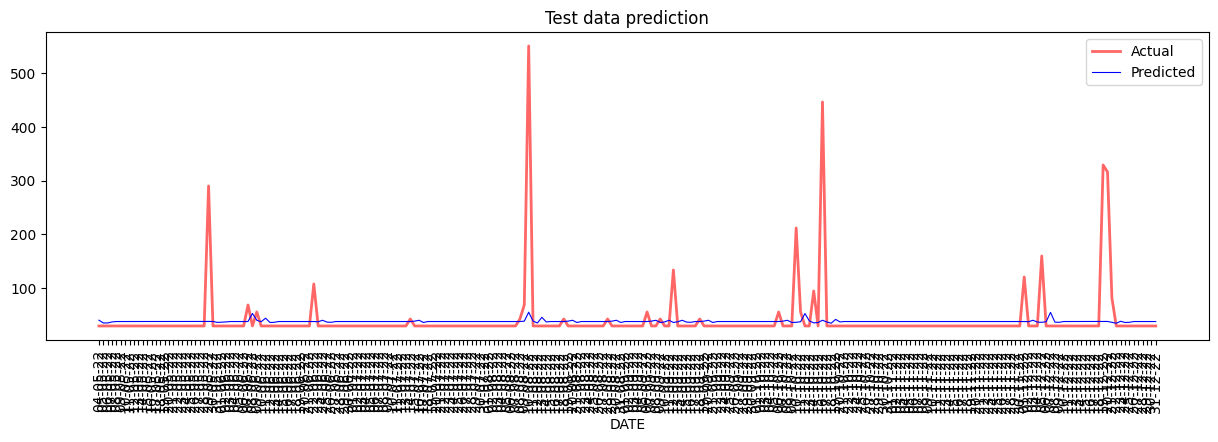

In [200]:
plt.figure(figsize=(15,4))
plt.plot(test_timestamps_prt, y_test_prt, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps_prt, y_test_pred_prt, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(test_timestamps_prt, pd.to_datetime(test_timestamps_prt).strftime('%d-%m-%y'), rotation=90)
plt.title("Test data prediction")
plt.show()

###Full dataset prediction

In [201]:
full_prt_indexes = dfOceanAtmo.index.values
full_prt_indexes_X = np.array([[j for j in full_prt_indexes[i:i+timesteps]] for i in range(0,len(full_prt_indexes)-timesteps+1)])[:,0]

full_prt = dfOceanAtmo[['INM_PREC_TOTAL']].values
full_prt = scaler.fit_transform(full_prt)

# Transforming to 2D tensor as per model input requirement
data_timesteps_prt = np.array([[j for j in full_prt[i:i+timesteps]] for i in range(0,len(full_prt)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps_prt.shape)

# Selecting inputs and outputs from data
X_full_prt, Y_full_prt = data_timesteps_prt[:,:timesteps-1],data_timesteps_prt[:,[timesteps-1]]

print("X shape: ", X_full_prt.shape,"\nY shape: ", Y_full_prt.shape)
print("X index: ", full_prt_indexes_X.shape)

Tensor shape:  (1822, 5)
X shape:  (1822, 4) 
Y shape:  (1822, 1)
X index:  (1822,)


In [202]:
# Make model predictions
Y_full_pred_prt = grid_search_prt.predict(X_full_prt).reshape(-1,1)

# Inverse scale and reshape
Y_full_pred_prt = scaler.inverse_transform(Y_full_pred_prt)
Y_full_prt = scaler.inverse_transform(Y_full_prt)

<Axes: xlabel='DATE'>

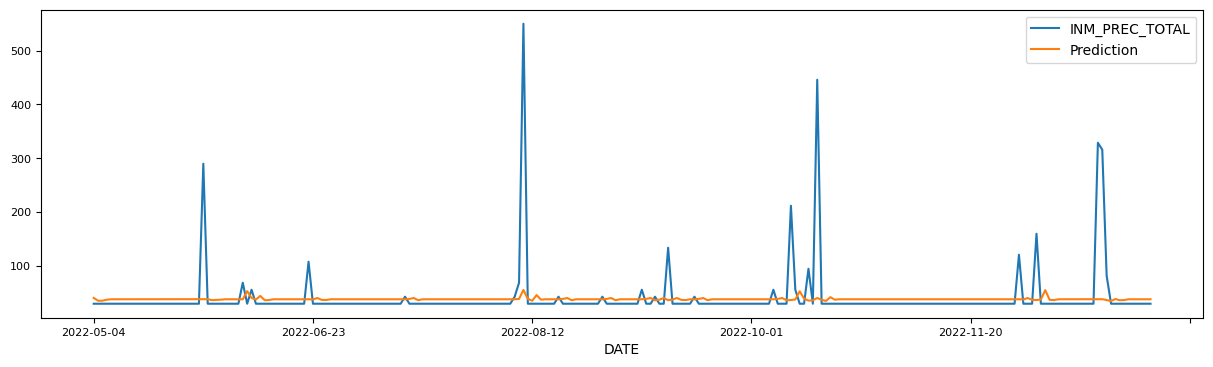

In [221]:
listY_prt = pd.DataFrame(y_test_prt.tolist(), columns=['INM_PREC_TOTAL'])
listY_pred_prt = pd.DataFrame(y_test_pred_prt.tolist(), columns=['Prediction'])
listX_idx_prt = pd.DataFrame(test_timestamps_prt.tolist(), columns=['DATE'])


dfTrain_prt = pd.concat([listX_idx_prt, listY_prt, listY_pred_prt], axis=1);
dfTrain_prt.set_index('DATE', inplace=True)

dfTrain_prt.plot(figsize=(15, 4), fontsize=8)

<Axes: xlabel='DATE'>

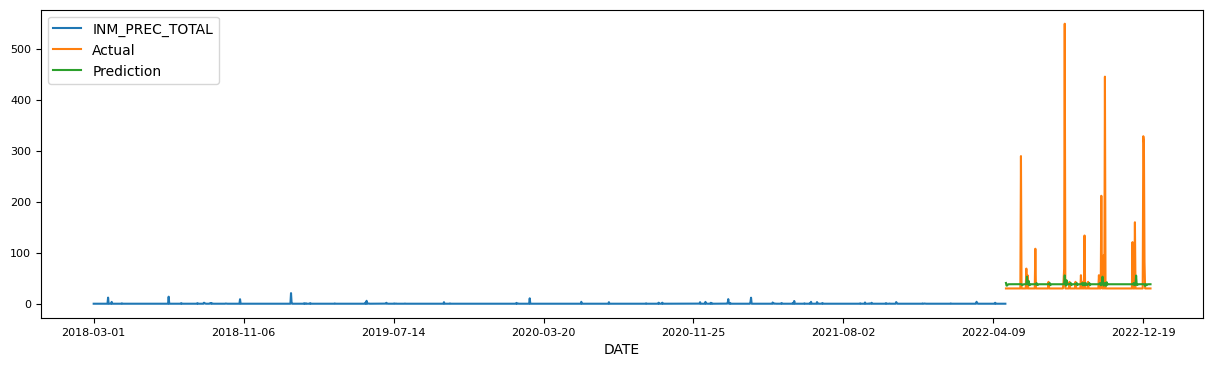

In [204]:
train_c_prt = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['INM_PREC_TOTAL']].rename(columns={'INM_PREC_TOTAL':'INM_PREC_TOTAL'})

df_pred_prt = pd.DataFrame(y_test_pred_prt.tolist(), columns=['Prediction'])
df_actual_prt = pd.DataFrame(y_test_prt.tolist(), columns=['Actual'])
df_dates_prt = pd.DataFrame(test_timestamps_prt.tolist(), columns=['DATE'])

df_conc_prt = pd.concat([df_dates_prt,df_actual_prt,df_pred_prt],axis=1)
df_conc_prt.set_index('DATE', inplace=True)


pd.concat([train_c_prt,df_conc_prt],axis=1).plot(figsize=(15, 4), fontsize=8)

#[INM_UMID_AR] Umidade relativa do *ar*

###Preparação dos dados para treinamento
* Filtragem e dimensionamento;


In [205]:
train_umi = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['INM_UMID_AR']]
test_umi = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['INM_UMID_AR']]

In [206]:
#Escalar dados
train_umi['INM_UMID_AR'] = scaler.fit_transform(train_umi)
test_umi['INM_UMID_AR'] = scaler.transform(test_umi)

In [207]:
# Converting to numpy arrays
train_data_umi = train_umi.values
test_data_umi = test_umi.values

In [208]:
train_data_timesteps_umi = np.array([[j for j in train_data_umi[i:i+timesteps]] for i in range(0,len(train_data_umi)-timesteps+1)])[:,:,0]
test_data_timesteps_umi = np.array([[j for j in test_data_umi[i:i+timesteps]] for i in range(0,len(test_data_umi)-timesteps+1)])[:,:,0]

print(test_data_timesteps_umi.shape)
print(train_data_timesteps_umi.shape)

(242, 5)
(1517, 5)


In [209]:
#train
x_train_umi, y_train_umi = train_data_timesteps_umi[:,:timesteps-1],train_data_timesteps_umi[:,[timesteps-1]]

#test
x_test_umi, y_test_umi = test_data_timesteps_umi[:,:timesteps-1],test_data_timesteps_umi[:,[timesteps-1]]

In [210]:
# XGBoost
cv_split_umi = TimeSeriesSplit(n_splits=2, test_size=timesteps)
model_umi = XGBRegressor()

parameters_umi = {  "max_depth": [3, 4, 6, 5],
                    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
                    "n_estimators": [100, 300, 500, 700, 900, 1000],
                    "colsample_bytree": [0.3, 0.5, 0.7]  }


grid_search_umi = GridSearchCV(estimator=model_umi, cv=cv_split_umi, param_grid=parameters_umi)
grid_search_umi.fit(x_train_umi, y_train_umi)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=5),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, import...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [211]:
# LGBM
#cv_split_umi = TimeSeriesSplit(n_splits=2, test_size=timesteps)
#model_umi = lgb.LGBMRegressor()
#parameters_umi = {
    #"max_depth": [3, 4, 6],
    #"num_leaves": [10, 20, 30],
    #"learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    #"n_estimators": [50, 100, 300],
    #"colsample_bytree": [0.3, 0.5, 0.7],
    #"force_col_wise": ["true"]
#}


#grid_search_umi = GridSearchCV(estimator=model_umi, cv=cv_split_umi, param_grid=parameters_umi)
#grid_search_umi.fit(x_train_umi, y_train_umi)

In [212]:
#predictions

y_train_pred_umi = grid_search_umi.predict(x_train_umi).reshape(-1,1)
y_test_pred_umi = grid_search_umi.predict(x_test_umi).reshape(-1,1)

In [213]:
#ReScaling orginial and predicted

y_train_umi = scaler.inverse_transform(y_train_umi)
y_test_umi = scaler.inverse_transform(y_test_umi)

y_train_pred_umi = scaler.inverse_transform(y_train_pred_umi)
y_test_pred_umi = scaler.inverse_transform(y_test_pred_umi)

In [214]:
train_timestamps_umi = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)].index[timesteps-1:]
test_timestamps_umi = dfOceanAtmo[test_start_dt:].index[timesteps-1:]

In [223]:
print('MAPE for training data: ', mape(pd.DataFrame(y_test_pred_umi), pd.DataFrame(y_test_umi))*100, '%')

MAPE for training data:  0   12.87
dtype: float64 %


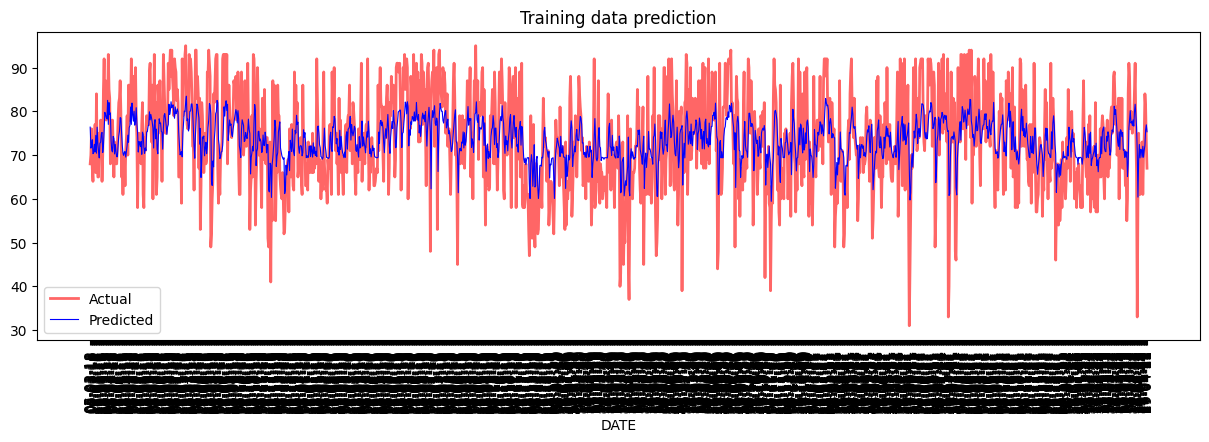

In [215]:
plt.figure(figsize=(15,4))
plt.plot(train_timestamps_umi, y_train_umi, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps_umi, y_train_pred_umi, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(train_timestamps_umi, pd.to_datetime(train_timestamps_umi).strftime('%d-%m-%y'), rotation=90)
plt.title("Training data prediction")
plt.show()

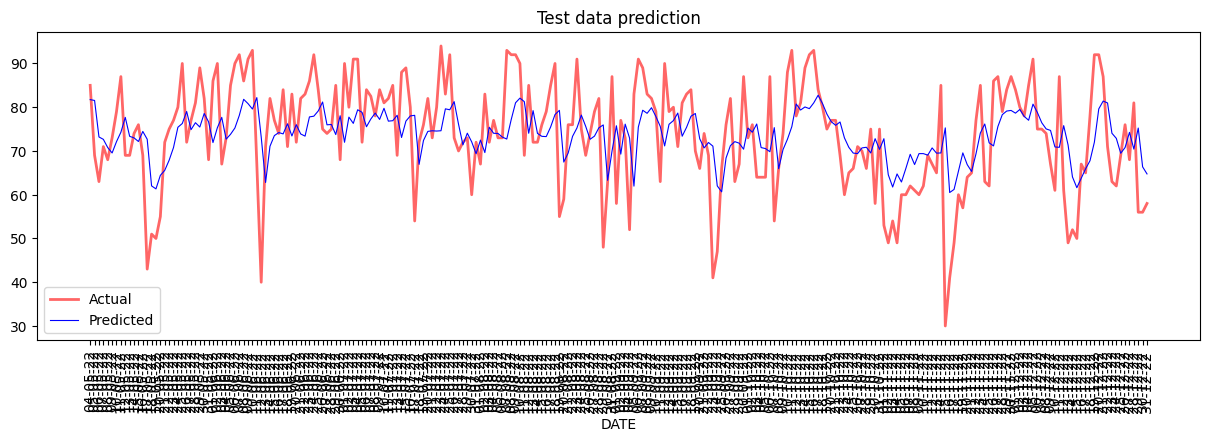

In [216]:
plt.figure(figsize=(15,4))
plt.plot(test_timestamps_umi, y_test_umi, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps_umi, y_test_pred_umi, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DATE')
plt.xticks(test_timestamps_umi, pd.to_datetime(test_timestamps_umi).strftime('%d-%m-%y'), rotation=90)
plt.title("Test data prediction")
plt.show()

<Axes: xlabel='DATE'>

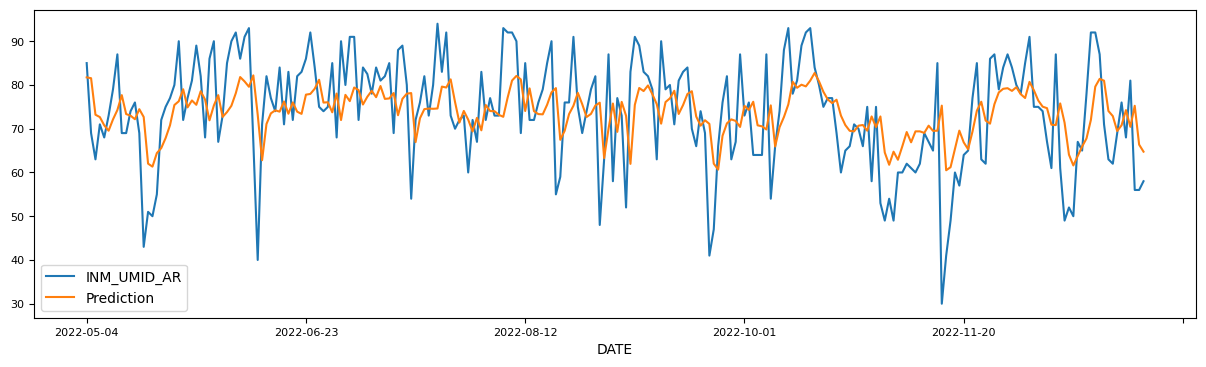

In [222]:
listY_umi = pd.DataFrame(y_test_umi.tolist(), columns=['INM_UMID_AR'])
listY_pred_umi = pd.DataFrame(y_test_pred_umi.tolist(), columns=['Prediction'])
listX_idx_umi = pd.DataFrame(test_timestamps_umi.tolist(), columns=['DATE'])


dfTrain_umi = pd.concat([listX_idx_umi, listY_umi, listY_pred_umi], axis=1);
dfTrain_umi.set_index('DATE', inplace=True)

dfTrain_umi.plot(figsize=(15, 4), fontsize=8)

###Full dataset prediction

In [217]:
full_umi_indexes = dfOceanAtmo.index.values
full_umi_indexes_X = np.array([[j for j in full_umi_indexes[i:i+timesteps]] for i in range(0,len(full_umi_indexes)-timesteps+1)])[:,0]

full_umi = dfOceanAtmo[['INM_UMID_AR']].values
full_umi = scaler.fit_transform(full_umi)

# Transforming to 2D tensor as per model input requirement
data_timesteps_umi = np.array([[j for j in full_umi[i:i+timesteps]] for i in range(0,len(full_umi)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps_umi.shape)

# Selecting inputs and outputs from data
X_full_umi, Y_full_umi = data_timesteps_umi[:,:timesteps-1],data_timesteps_umi[:,[timesteps-1]]

print("X shape: ", X_full_umi.shape,"\nY shape: ", Y_full_umi.shape)
print("X index: ", full_umi_indexes_X.shape)

Tensor shape:  (1822, 5)
X shape:  (1822, 4) 
Y shape:  (1822, 1)
X index:  (1822,)


In [218]:
# Make model predictions
Y_full_pred_umi = grid_search_umi.predict(X_full_umi).reshape(-1,1)

# Inverse scale and reshape
Y_full_pred_umi = scaler.inverse_transform(Y_full_pred_umi)
Y_full_umi = scaler.inverse_transform(Y_full_umi)

<Axes: xlabel='DATE'>

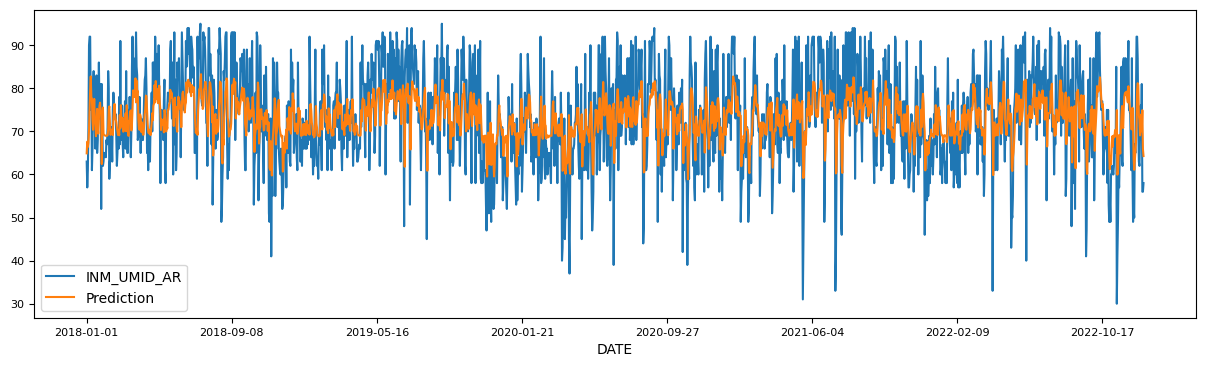

In [219]:
listY_umi = pd.DataFrame(Y_full_umi.tolist(), columns=['INM_UMID_AR'])
listY_pred_umi = pd.DataFrame(Y_full_pred_umi.tolist(), columns=['Prediction'])
listX_idx_umi = pd.DataFrame(full_umi_indexes_X.tolist(), columns=['DATE'])


dfFull_umi = pd.concat([listX_idx_umi, listY_umi, listY_pred_umi], axis=1);
dfFull_umi.set_index('DATE', inplace=True)

dfFull_umi.plot(figsize=(15, 4), fontsize=8)

<Axes: xlabel='DATE'>

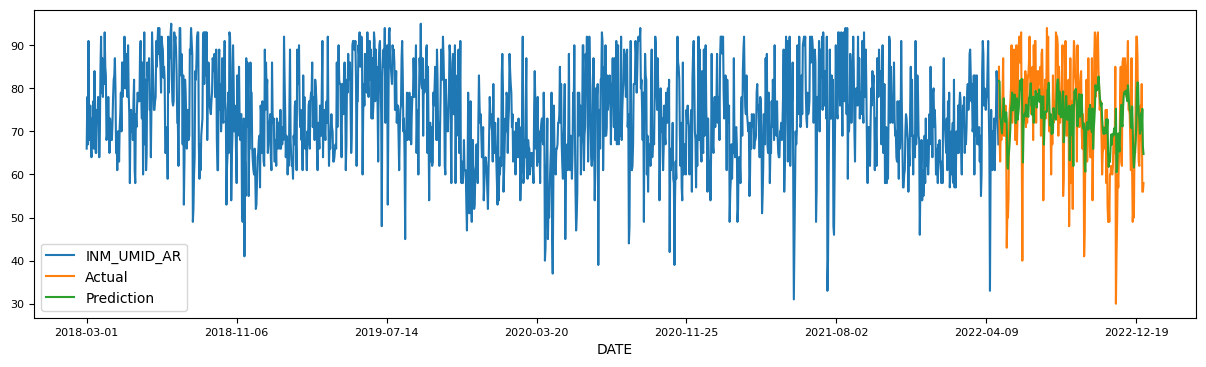

In [220]:
train_c_umi = dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['INM_UMID_AR']].rename(columns={'INM_UMID_AR':'INM_UMID_AR'})

df_pred_umi = pd.DataFrame(y_test_pred_umi.tolist(), columns=['Prediction'])
df_actual_umi = pd.DataFrame(y_test_umi.tolist(), columns=['Actual'])
df_dates_umi = pd.DataFrame(test_timestamps_umi.tolist(), columns=['DATE'])

df_conc_umi = pd.concat([df_dates_umi,df_actual_umi,df_pred_umi],axis=1)
df_conc_umi.set_index('DATE', inplace=True)


pd.concat([train_c_umi,df_conc_umi],axis=1).plot(figsize=(15, 4), fontsize=8)